In [26]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Set up device to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [27]:
# 1. Data Loading and Preprocessing
# Define strong data augmentation for contrastive learning
transform_strong = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.5, 1.0)),
    # Randomly crop to a smaller portion
    transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
    # Random color jitter
    transforms.RandomGrayscale(p=0.2),
    # Convert image to grayscale with a probability
    transforms.RandomHorizontalFlip(),
    # Random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # Normalize to [-1, 1] range
])

# Define a custom dataset class to generate 2 different augmented views of the same image
class CIFAR10Pair(Dataset):
    def __init__(self, root='./data', train=True, transform1=None, transform2=None):
        self.cifar10 = datasets.CIFAR10(root=root, train=train, download=True)
        self.transform1 = transform1
        self.transform2 = transform2

    def __getitem__(self, index):
        img, _ = self.cifar10[index]
        # Ignore the label, as we are doing self-supervised learning
        img1 = self.transform1(img)
        # First augmented view
        img2 = self.transform2(img)
        # Second augmented view
        return img1, img2

    def __len__(self):
        return len(self.cifar10)

# Apply strong data augmentation to both views in CIFAR10Pair
train_dataset = CIFAR10Pair(transform1=transform_strong, transform2=transform_strong)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 2. Model Definition
# Define a simple CNN model with a projection head for feature learning
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(128 * 8 * 8, 256)
        # Fully connected layer to produce features
        self.projection_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            # Normalize output before second layer
            nn.Linear(128, 128)
            # Output projection
        )

        # Initialize weights for layers
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.projection_head[0].weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
    # Convolutional layers with ReLU activation and Max Pooling
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(2)(x)
        x = x.view(x.size(0), -1)
        # Flatten feature map
        feature = self.fc(x)
        # Generate features
        projection = self.projection_head(feature)
        # Projected feature for contrastive learning
        return feature, projection

model = SimpleCNN().to(device)
# Move model to device (GPU if available)

# 3. Non-contrastive learning (DirectPred) implementation
# Define a loss function for DirectPred approach
class DirectPredLoss(nn.Module):
    def __init__(self):
        super(DirectPredLoss, self).__init__()
        self.criterion = nn.MSELoss()
        # Mean squared error loss

    def forward(self, proj1, proj2):
        noise = torch.randn_like(proj1) * 1e-2
        # Add small noise to projections
        proj1 = proj1 + noise
        proj2 = proj2 + noise
        return self.criterion(proj1, proj2)

# Define training loop for DirectPred
def train_directpred(model, train_loader, epochs=5, lr=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # Adam optimizer
    criterion = DirectPredLoss()
    # Use DirectPred loss function
    model.train()

    directpred_losses = []
    for epoch in range(epochs):
        total_loss = 0.0
        for x1, x2 in train_loader:
            x1, x2 = x1.to(device), x2.to(device)
            # Move inputs to device

            optimizer.zero_grad()
            _, proj1 = model(x1)
            # Get projection for first augmented view
            _, proj2 = model(x2)
            # Get projection for second augmented view
            loss = criterion(proj1, proj2)
            # Calculate DirectPred loss

            loss.backward()
            # Backpropagate
            optimizer.step()
            # Update model weights
            total_loss += loss.item()
            # Accumulate batch loss

        avg_loss = total_loss / len(train_loader)
        # Calculate average loss per epoch
        directpred_losses.append(avg_loss)
        print(f'[DirectPred] Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

    return directpred_losses

# 4. Contrastive learning (SimCLR) implementation
# Define a contrastive loss function for SimCLR
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.3):  # Adjust temperature to 0.3
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        # Temperature parameter for scaling similarities
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, projections):
        # Normalize projections for cosine similarity calculation
        projections = projections / projections.norm(dim=1, keepdim=True)
        batch_size = projections.shape[0]
        labels = torch.arange(batch_size).to(projections.device)
        # Identity labels for contrastive learning

        # Compute cosine similarity matrix
        similarity_matrix = torch.mm(projections, projections.t()) / self.temperature
        loss = self.criterion(similarity_matrix, labels)
        # Contrastive loss calculation
        return loss

# Define training loop for SimCLR
def train_simclr(model, train_loader, epochs=5, lr=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # Adam optimizer
    criterion = NTXentLoss(temperature=0.3)  # SimCLR loss function with temperature scaling
    model.train()

    simclr_losses = []
    for epoch in range(epochs):
        total_loss = 0.0
        for x1, x2 in train_loader:
            x1, x2 = x1.to(device), x2.to(device)
            # Move inputs to device
            optimizer.zero_grad()
            _, proj1 = model(x1)
            # Get projection for first augmented view
            _, proj2 = model(x2)
            # Get projection for second augmented view
            projections = torch.cat([proj1, proj2], dim=0)
            # Concatenate projections for contrastive loss
            loss = criterion(projections)
            # Calculate SimCLR loss

            loss.backward()
            # Backpropagate
            optimizer.step()
            # Update model weights
            total_loss += loss.item()
            # Accumulate batch loss

        avg_loss = total_loss / len(train_loader)
        # Calculate average loss per epoch
        simclr_losses.append(avg_loss)
        print(f'[SimCLR] Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

    return simclr_losses

Files already downloaded and verified


In [28]:
# 5. Performance comparison and visualization
# (1) Embedding Space Visualization using PCA
def plot_embedding_space(projections, method='PCA'):
    projections = projections.detach().cpu().numpy()
    if method == 'PCA':
        reduced_data = PCA(n_components=2).fit_transform(projections)
    elif method == 't-SNE':
        reduced_data = TSNE(n_components=2).fit_transform(projections)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.5)
    plt.title(f'Embedding Space ({method})')
    plt.show()

# (2) Positive/Negative Pair Similarity
def plot_similarity_over_epochs(similarities):
    epochs = range(1, len(similarities['positive']) + 1)
    plt.plot(epochs, similarities['positive'], label='Positive Pair Similarity')
    plt.plot(epochs, similarities['negative'], label='Negative Pair Similarity')
    plt.xlabel('Epoch')
    plt.ylabel('Average Similarity')
    plt.legend()
    plt.title('Positive/Negative Pair Similarity Over Epochs')
    plt.show()

# (3) Loss per Epoch, Separated
def plot_loss_curves(directpred_losses, simclr_losses):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(directpred_losses, label='DirectPred Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('DirectPred Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(simclr_losses, label='SimCLR Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('SimCLR Loss')
    plt.legend()

    plt.show()

Training DirectPred model...
[DirectPred] Epoch [1/5], Loss: 0.0321
[DirectPred] Epoch [2/5], Loss: 0.0019
[DirectPred] Epoch [3/5], Loss: 0.0007
[DirectPred] Epoch [4/5], Loss: 0.0005
[DirectPred] Epoch [5/5], Loss: 0.0003


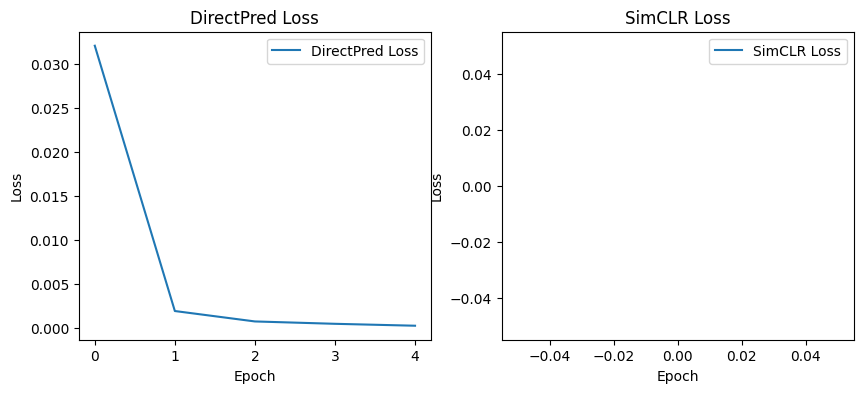


Training SimCLR model...
[SimCLR] Epoch [1/5], Loss: 2.0259
[SimCLR] Epoch [2/5], Loss: 1.7986
[SimCLR] Epoch [3/5], Loss: 1.7833
[SimCLR] Epoch [4/5], Loss: 1.7805
[SimCLR] Epoch [5/5], Loss: 1.7676


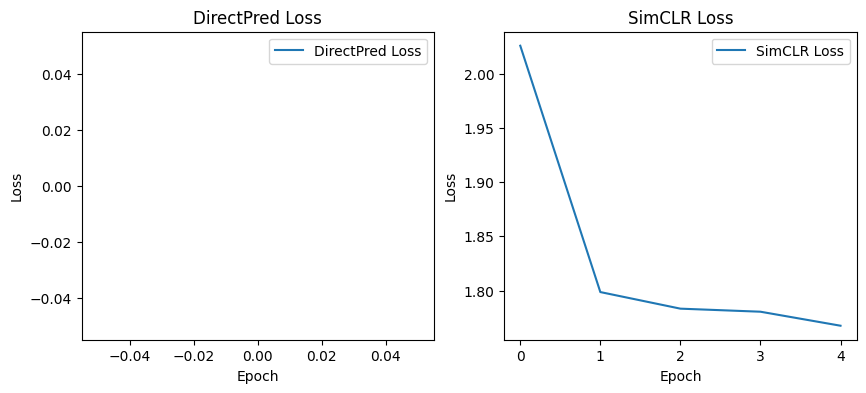

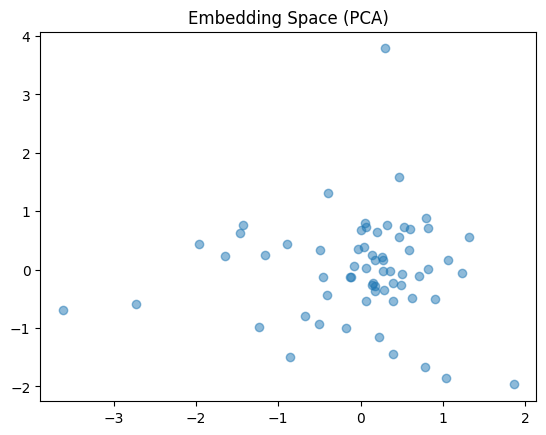

In [29]:
# Main execution block
if __name__ == "__main__":

    print("Training DirectPred model...")
    directpred_losses = train_directpred(model, train_loader, epochs=5, lr=1e-4)
    plot_loss_curves(directpred_losses, [])

    print("\nTraining SimCLR model...")
    simclr_losses = train_simclr(model, train_loader, epochs=5, lr=1e-4)
    plot_loss_curves([], simclr_losses)

    # Additional Visualization after Training
    # Run Embedding Visualization
    for batch in train_loader:
        _, proj1 = model(batch[0].to(device))
        plot_embedding_space(proj1, method='PCA')
        break

In [2]:
!pip freeze > requirements.txt

!cat requirements.txt

absl-py==1.4.0
accelerate==0.34.2
aiohappyeyeballs==2.4.3
aiohttp==3.10.10
aiosignal==1.3.1
alabaster==0.7.16
albucore==0.0.19
albumentations==1.4.20
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.20.0
astropy==6.1.4
astropy-iers-data==0.2024.10.28.0.34.7
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.2.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bigframes==1.25.0
bigquery-magics==0.4.0
bleach==6.2.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.4.3
Bottleneck==1.4.2
bqplot==0.12.43
branca==0.8.0
CacheControl==0.14.0
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.8.30
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.0
chex==0.1.87
clarabel==0.9.0
click==8.1.7
cloudpathlib==0.20.0
cloudpickle==3.1.0
cmake==3.30.5
cmdstanpy==1.2.4
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6
contourpy==1